# Visium mouse brain

In [1]:
import scanpy as sc
import spacec as sp
import warnings
warnings.filterwarnings("ignore")

2025-04-14 15:45:26.003866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:root: * TissUUmaps version: 3.1.1.6


In [2]:
data_dir = '/Users/yuqitan/Nolan Lab Dropbox/Yuqi Tan/analysis_pipeline/Manuscript/NatComm_091624/revision_031225/analysis/app_spatial_transcriptomics/'
output_dir = '/Users/yuqitan/Nolan Lab Dropbox/Yuqi Tan/analysis_pipeline/Manuscript/NatComm_091624/revision_031225/analysis/app_spatial_transcriptomics/output/'

In [3]:
# trying to read the imc
adata = sc.read(data_dir + 'visium_ffpe_mouse_brain_adata.h5ad')
adata

AnnData object with n_obs × n_vars = 2264 × 19465
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
adata.obs['x'] = [sublist[0] for sublist in adata.obsm['spatial']]
adata.obs['y'] = [sublist[1] for sublist in adata.obsm['spatial']]
adata.obs['in_tissue'] = adata.obs['in_tissue'].astype(str)

## Clustering

In [36]:
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=10)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.5)

In [37]:
adata

AnnData object with n_obs × n_vars = 2264 × 19465
    obs: 'in_tissue', 'array_row', 'array_col', 'x', 'y', 'leiden', 'CN_k20_n6', 'CN_k20_n10', 'CN_k20_n20'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'spatial', 'pca', 'neighbors', 'leiden', 'leiden_colors', 'Centroid_k20_n6', 'Centroid_k20_n10', 'Centroid_k20_n20', 'CN_k20_n20_colors', 'CN_k20_n10_colors'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

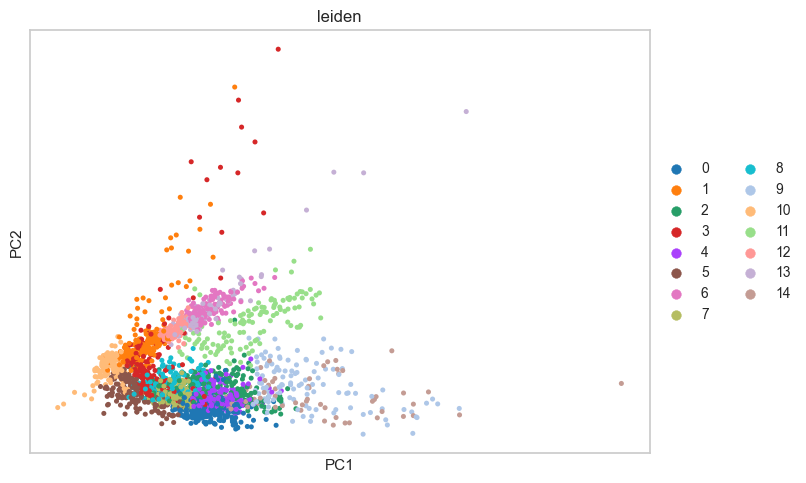

In [38]:
sc.pl.pca(adata, color = ['leiden'], wspace=0.5) 

## Scatter plot

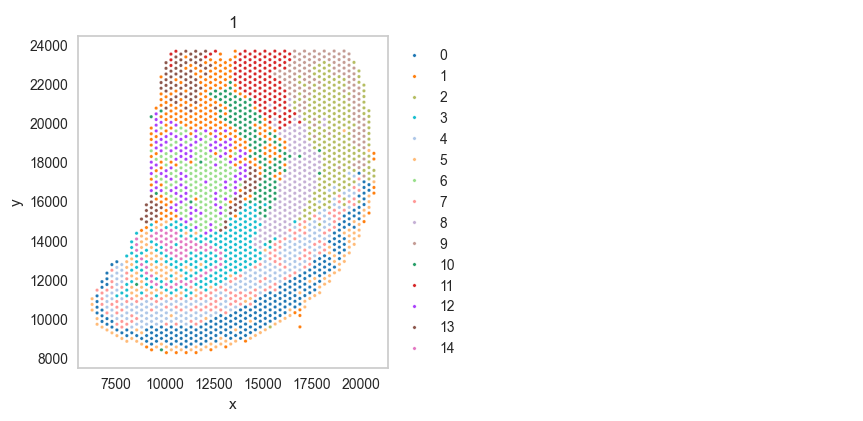

In [39]:
df = catplot(
    adata, 
    color = "leiden", # specify group column name here (e.g. celltype_fine)
    unique_region = "in_tissue", # specify unique_regions here
    X='x', Y='y', # specify x and y columns here
    n_columns=2, # adjust the number of columns for plotting here (how many plots do you want in one row?)
    palette=None, #default is None which means the color comes from the anndata.uns that matches the UMAP
    savefig=False, # save figure as pdf
    output_fname = "", # change it to file name you prefer when saving the figure
    output_dir= output_dir, # specify output directory here (if savefig=True)
)

## Cell type composition

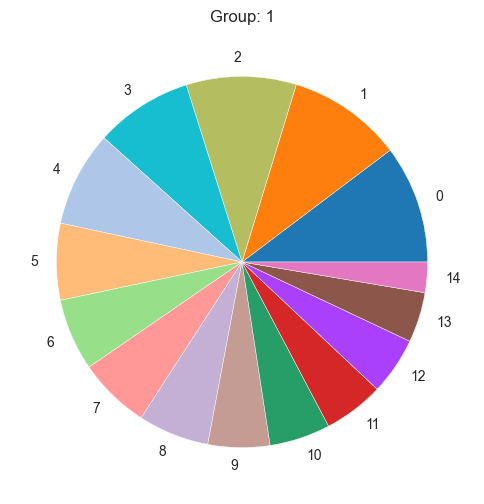

In [40]:
sp.pl.create_pie_charts(
    adata,
    color = "leiden", 
    grouping = "in_tissue", 
    show_percentages=False,
    palette=None, #default is None which means the color comes from the anndata.uns that matches the UMAP
    savefig=False, # change it to true if you want to save the figure
    output_fname = "", # change it to file name you prefer when saving the figure
    output_dir = output_dir #output directory for the figure
)

## Neighborhood analysis

In [64]:
adata = sp.tl.neighborhood_analysis(
    adata, 
    unique_region = "in_tissue", 
    cluster_col = "leiden", 
    X = 'x', Y = 'y',
    k = 20, # k nearest neighbors
    n_neighborhoods = 10, #number of CNs
    elbow = False)

Starting: 1/1 : 1
Finishing: 1/1 : 1 0.016676902770996094 0.01679396629333496


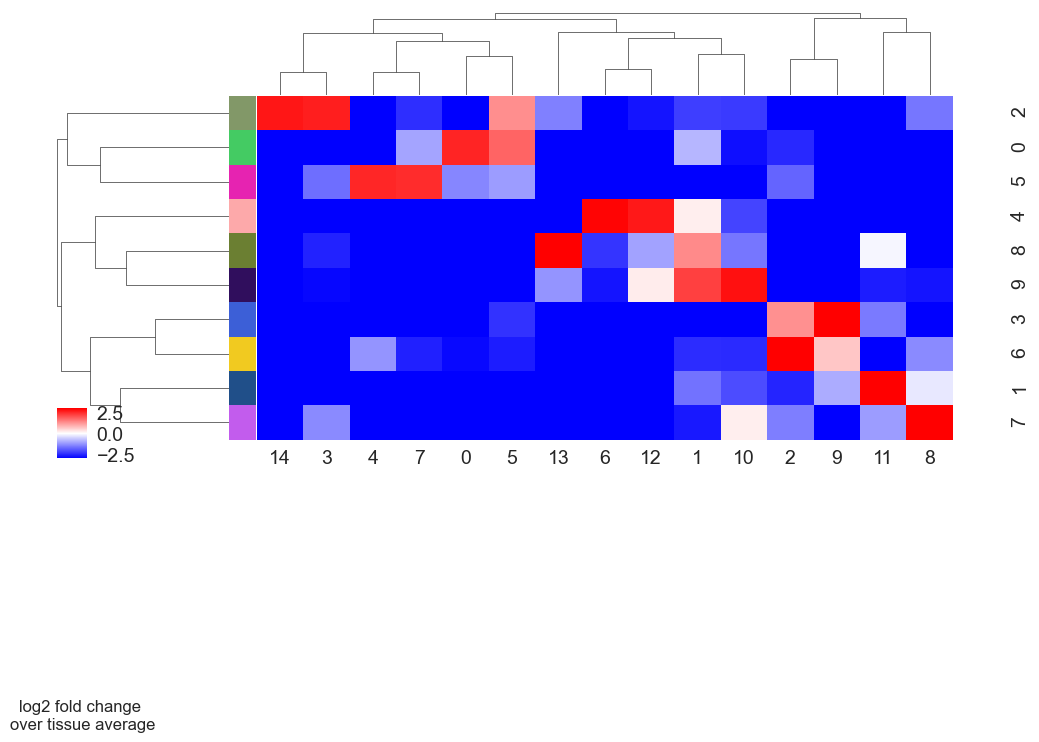

In [65]:
sp.pl.cn_exp_heatmap(
    adata, # anndata
    cluster_col = "leiden", # cell type column
    cn_col = "CN_k20_n10", # CN column
    palette=None, # color palette for CN
    savefig = False, # save the figure
    output_dir = output_dir, # output directory
    rand_seed = 1 # random seed for reproducibility
)

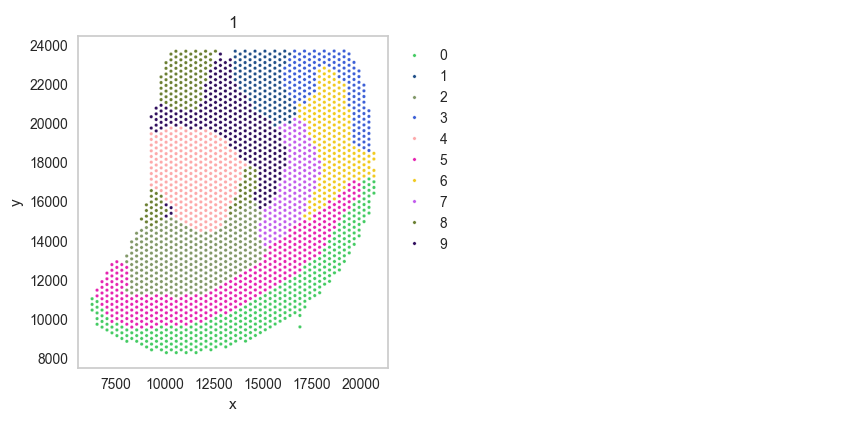

In [43]:
df = catplot(
    adata, 
    color = "CN_k20_n10", # specify group column name here (e.g. celltype_fine)
    unique_region = "in_tissue", # specify unique_regions here
    X='x', Y='y', # specify x and y columns here
    n_columns=2, # adjust the number of columns for plotting here (how many plots do you want in one row?)
    palette=None, #default is None which means the color comes from the anndata.uns that matches the UMAP
    savefig=False, # save figure as pdf
    output_fname = "", # change it to file name you prefer when saving the figure
    output_dir= output_dir, # specify output directory here (if savefig=True)
)

## Spatial context map

Starting: 1/1 : 1
Finishing: 1/1 : 1 0.03047490119934082 0.030478715896606445
18 0.017226148409894004


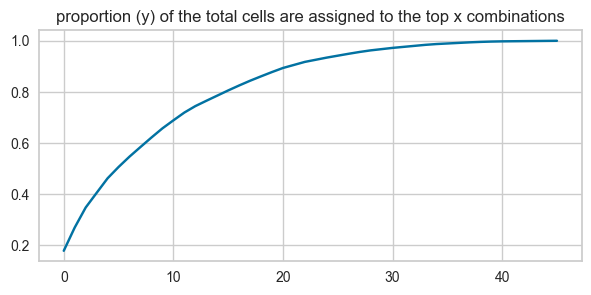

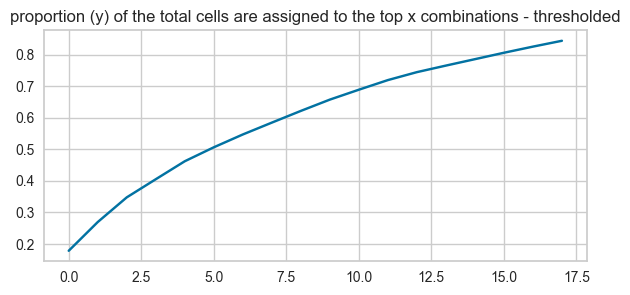

In [45]:
cnmap_dict_visium = sp.tl.build_cn_map(
    adata = adata, # adata object
    cn_col = "CN_k20_n10",# column with CNs
    palette = None, # color dictionary
    unique_region = 'in_tissue',# column with unique regions
    k = 70, # number of neighbors
    X='x', Y='y',  # coordinates
    threshold = 0.85, # threshold for percentage of cells in CN
    per_keep_thres = 0.85,) # threshold for percentage of cells in CN

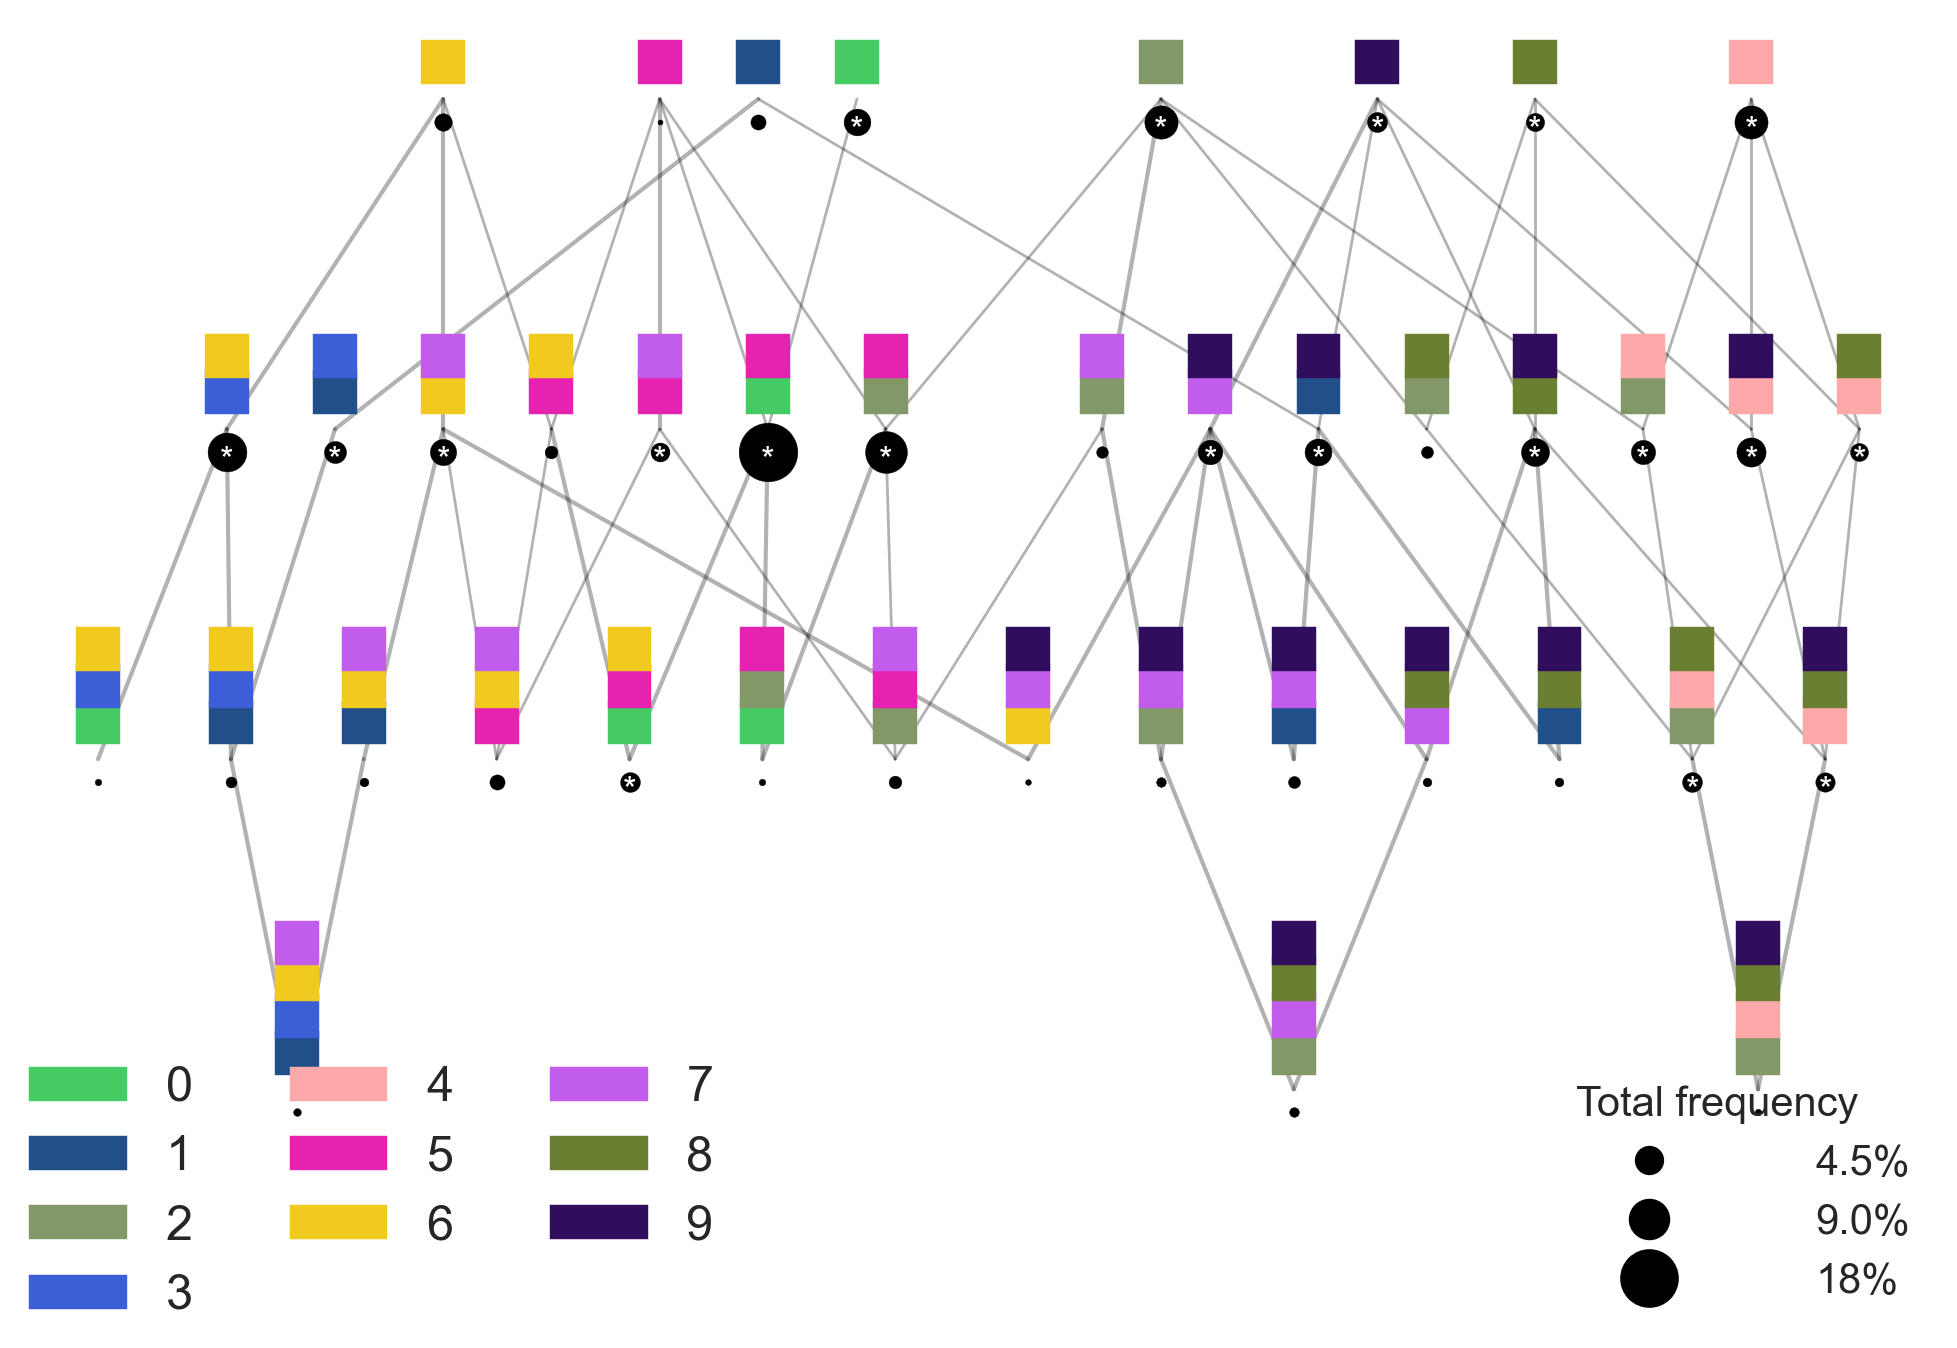

In [57]:
sp.pl.cn_map(cnmap_dict = cnmap_dict_visium, # dictionary from the previous step
        adata = adata, # adata object
        cn_col = "CN_k20_n10", # column with CNs used to color the plot
        palette = None, # color dictionary
        figsize=(25, 15), # figure size
        savefig=False, # save figure as pdf
        output_fname = "", # change it to file name you prefer when saving the figure
        output_dir= output_dir # specify output directory here (if savefig=True)
    )

## Barycentric coordinate plots

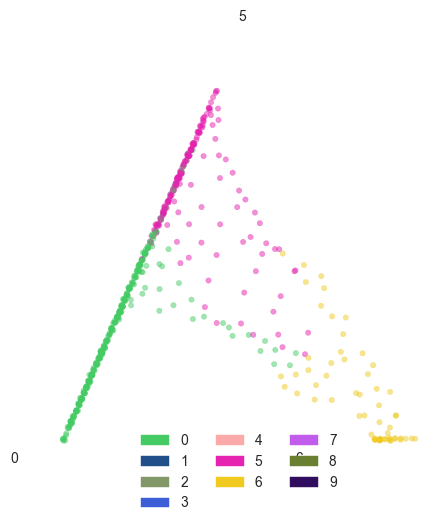

In [66]:
sp.pl.BC_projection(adata=adata,
    cnmap_dict = cnmap_dict_visium, # dictionary from the previous step
    cn_col = "CN_k20_n10", # column with CNs
    plot_list = [0, 5, 6], # list of CNs to plot (three for the corners)
    cn_col_annt =  "CN_k20_n10", # column with CNs used to color the plot
    palette = None, # color dictionary
    figsize=(5, 5), # figure size
    rand_seed = 1, # random seed for reproducibility
    n_num = None, # number of neighbors
    threshold = 0.6) # threshold for percentage of cells in CN